In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

## Crash data

In [2]:
df = pd.read_csv("../data/raw/Motor_Vehicle_Collisions_-_Crashes.csv")

# drop useless columns
df = df.drop(columns=["ZIP CODE", "LOCATION", "ON STREET NAME", "CROSS STREET NAME", "OFF STREET NAME", "COLLISION_ID"])

# convert "CRASH DATE" from object to datetime
df[["CRASH DATE"]] = pd.to_datetime(df[["CRASH DATE"]].stack()).unstack()

/tmp/ipykernel_196/2113288726.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/Motor_Vehicle_Collisions_-_Crashes.csv")


In [3]:
# so that filtering out the date of crashes is a lot easier
df = df[df["CRASH DATE"] > datetime(2016, 12, 31)]
df = df[df["CRASH DATE"] < datetime(2020, 1, 1)]

# the time of the crash needs to be converted to a consistent format (e.g. 2:10 should be 02:10)
# the "CRASH TIME" column is located at index 1
for i in range(df.shape[0]):
    time = df.iat[i, 1]
    if len(time) == 4:
        time = f"0{time}"
        df.iat[i, 1] = time

df.head()


,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
20,2019-05-21,22:50,BROOKLYN,40.697540,-73.98312,0.0,0.0,0,0,0,...,Passing or Lane Usage Improper,Unspecified,NaN,NaN,NaN,�MBU,Taxi,NaN,NaN,NaN
1059,2019-04-17,00:49,NaN,40.651974,-73.86542,3.0,0.0,0,0,0,...,Following Too Closely,Unspecified,NaN,NaN,NaN,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
20389,2019-07-22,08:20,BROOKLYN,40.615433,-73.91388,0.0,0.0,0,0,0,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,NaN,Sedan,Sedan,NaN,NaN,NaN
33658,2019-10-19,17:20,NaN,NaN,NaN,0.0,0.0,0,0,0,...,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,Sedan,Sedan,NaN,NaN,NaN
38166,2017-12-09,20:05,NaN,NaN,NaN,1.0,0.0,1,0,0,...,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674056 entries, 20 to 963176
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH DATE                     674056 non-null  datetime64[ns]
 1   CRASH TIME                     674056 non-null  object        
 2   BOROUGH                        429211 non-null  object        
 3   LATITUDE                       627643 non-null  float64       
 4   LONGITUDE                      627643 non-null  float64       
 5   NUMBER OF PERSONS INJURED      674040 non-null  float64       
 6   NUMBER OF PERSONS KILLED       674026 non-null  float64       
 7   NUMBER OF PEDESTRIANS INJURED  674056 non-null  int64         
 8   NUMBER OF PEDESTRIANS KILLED   674056 non-null  int64         
 9   NUMBER OF CYCLIST INJURED      674056 non-null  int64         
 10  NUMBER OF CYCLIST KILLED       674056 non-null  int64         
 11 

## Twilight data

In [5]:
tdf = pd.read_csv("../data/raw/twilight.csv")

# only the civil twilight data will be used. Why? Because although it occurs after sunset/before sunrise, 
# the sky is still bright enough that it doesn't require artificial lighting. When civil ends and nautical twilight begins
# (or the opposite during sunrise), the sky is then dark enough to require artificial lighting.
tdf = tdf.drop(columns=["begin_nau", "end_nau", "begin_astro", "end_astro"])

# convert time to 24hr format
for i in range(tdf.shape[0]):
    # this always ends in AM
    begin = f"0{tdf.iat[i, -2][0:4]}"
    # this always ends in PM
    end = f"{str(int(tdf.iat[i, -1][0]) + 12)}{tdf.iat[i, -2][1:4]}"

    tdf.iat[i, -2] = begin
    tdf.iat[i, -1] = end

tdf

,date,begin_civ,end_civ
0,"Tue, January 1",06:49,17:49
1,"Wed, January 2",06:49,17:49
2,"Thu, January 3",06:49,17:49
3,"Fri, January 4",06:49,17:49
4,"Sat, January 5",06:49,17:49
...,...,...,...
360,"Fri, December 27",06:48,17:48
361,"Sat, December 28",06:48,17:48
362,"Sun, December 29",06:48,17:48
363,"Mon, December 30",06:48,17:48


# DATA PREPROCESSING
## 1: Season
## 2: Daylight

In [6]:
# final data frame
fdf = df.iloc[:, [0, 1, 2, 3, 4]].copy().sort_values(by=["CRASH DATE", "CRASH TIME"])
fdf.head()

,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE
947253,2017-01-01,00:00,BROOKLYN,40.632427,-73.94083
947318,2017-01-01,00:00,NaN,40.735940,-73.85887
948255,2017-01-01,00:00,NaN,40.726406,-73.98618
951486,2017-01-01,00:00,QUEENS,40.700170,-73.90921
952518,2017-01-01,00:00,NaN,NaN,NaN


In [7]:
# from "CRASH TIME", extract info about whether it is night or day
# from "CRASH DATE", extract info about its season
crash_time = fdf.iloc[:, 1].to_numpy()
daylight_start = tdf.iloc[:, -2].to_numpy()
daylight_end = tdf.iloc[:, -1].to_numpy()

season = []
daylight = []
for i in range(fdf.shape[0]):
    # DAYLIGHT
    # fdf.iloc[i, 0] is the crash date
    # yday = 0 for 1 Jan, or = 1 for 2 Jan, or = 364 for 31 Dec, etc, 
    # which will be used as the index for the twilight data
    yday = fdf.iloc[i, 0].timetuple().tm_yday - 1
        

    if (crash_time[i] < daylight_start[yday]) or (crash_time[i] > daylight_end[yday]):
        daylight.append("night")
    else:
        daylight.append("day")

    # SEASON
    month = fdf.iloc[i, 0].timetuple().tm_mon
    if month in [12, 1, 2]:
        season.append("winter")
    if month in [3, 4, 5]:
        season.append("spring")
    if month in [6, 7, 8]:
        season.append("summer")
    if month in [9, 10, 11]:
        season.append("autumn")

fdf["season"] = season
fdf["daylight"] = daylight

fdf.head(3)

,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,season,daylight
947253,2017-01-01,00:00,BROOKLYN,40.632427,-73.94083,winter,night
947318,2017-01-01,00:00,NaN,40.735940,-73.85887,winter,night
948255,2017-01-01,00:00,NaN,40.726406,-73.98618,winter,night


In [8]:
fdf["daylight"].value_counts()

day      487229
night    186827
Name: daylight, dtype: int64

It seems like crashes occur more during the day than it is during the night. However, we have to take into account that the number of vehicles outside is much higher during the day than night.

In [9]:
df["CRASH TIME"].value_counts()

00:00    10454
16:00    10244
17:00    10021
15:00     9587
14:00     9277
         ...  
04:02       23
04:31       23
02:59       21
03:53       21
03:34       21
Name: CRASH TIME, Length: 1440, dtype: int64

This one is so funny, I guess the police or whoever's responsible filling in the crash time loves a nice even number. I mean, I can't blame them, I love even numbers too.

The 00:00 seems to be weirdly high, which is probably because the crashes whose time are not recorded are automatically allocated to 00:00.

## 3: Speed

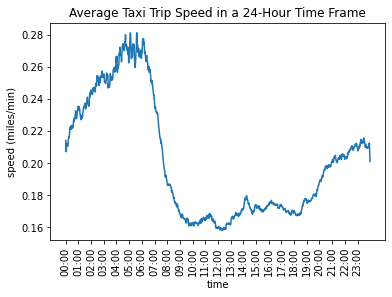

In [10]:
sdf = pd.read_csv("../data/curated/speed.csv")  # speed data frame
sdf = sdf.rename(columns={"Unnamed: 0": "minute"})

import matplotlib.pyplot as plt
# before plotting, convert minute to HH:MM for readability
minute1 = sdf["minute"].tolist()
hour = [i // 60 for i in minute1]
minute2 = [i % 60 for i in minute1]
minute3 = ["%02d:%02d" % (hour[i], minute2[i]) for i in minute1]

# now plot
plt.plot(minute3, sdf["avg_speed"])
ticks = plt.xticks(minute3[::60], rotation=90)
plt.xlabel("time")
plt.ylabel("speed (miles/min)")
plt.title("Average Taxi Trip Speed in a 24-Hour Time Frame")
plt.savefig("../plots/speed.png")

Based on a careful inspection at the graph, discretisations will be implemented as follows (I will discretise based on a fixed time value instead of using speed thresholds, simply because the data is taken from a random sample of the entire 2019 dataset, which if it were re-done will result in an inconsistent time value during discretisation):

normal: 08:00 - 20:00

fast: 07:00 - 08:00, 20:00 - 02:00

empty: 02:00 - 07:00

How about rush hours? The average speed looks slower at 09:00 to about 13:00.
Answer: First of all, the speed difference is negligible (only 0.01 miles/min, which is equivalent to about 1 km/h), so it's likely that NYC does not have rush hours, but rather, rush day. One probable explanation is that rush hours likely still exist, but the effects can be felt more at public transports or at other places, because the roads are already full for the whole day such that it can hardly be seen when it gets fuller. Second, this speed data simply takes a random sample from all taxi trips in 2019, which does not take into account how the streets change during weekends and public holidays. In those days, it is likely that they don't have rush hours, so I believe interpreting each day as having a "rush day" instead of "rush hours" is the cleanest solution given the circumstances, given that the difference between normal and rush hour during the day is much smaller compared to the difference between any time of day and 4 AM.


One important thing to notice is that this speed data is highly correlated to when humans sleep, where the trips go faster when most people are asleep (hence less cars outside).

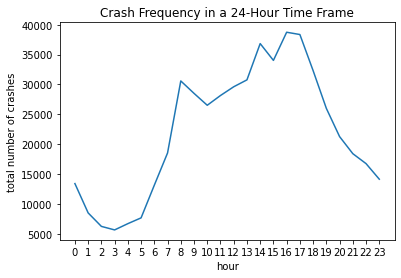

In [11]:
# compare that to crash frequency
hour = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
crash_freq = []
for time in range(0, 24):
    crash_num = 0
    for i in range(fdf.shape[0]):
        if time < 9:
            if (crash_time[i] > f"0{time}:00") and (crash_time[i] < f"0{time+1}:00"):
                crash_num += 1
        elif time == 9:
            if (crash_time[i] > f"0{time}:00") and (crash_time[i] < f"{time+1}:00"):
                crash_num += 1
        else:
            if (crash_time[i] > f"{time}:00") and (crash_time[i] < f"{time+1}:00"):
                crash_num += 1
    crash_freq.append(crash_num)

plt.plot(hour, crash_freq)
ticks = plt.xticks(hour)
plt.xlabel("hour")
plt.ylabel("total number of crashes")
plt.title("Crash Frequency in a 24-Hour Time Frame")
plt.savefig("../plots/crash_freq.png")

In [12]:
# discretise
speed = []
for i in range(fdf.shape[0]):
    if (crash_time[i] > "08:00") and (crash_time[i] < "20:00"):
        speed.append("normal")
    elif (crash_time[i] > "02:00") and (crash_time[i] < "07:00"):
        speed.append("empty")
    else:
        speed.append("fast")

fdf["speed"] = speed
fdf.sample(3)

,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,season,daylight,speed
621275,2018-06-30,11:37,MANHATTAN,40.760150,-73.99880,summer,day,normal
857845,2017-06-30,08:30,BRONX,40.877365,-73.88533,summer,day,normal
786518,2017-10-08,11:00,QUEENS,40.733604,-73.84995,autumn,day,normal


## 4: Location

In [13]:
import geopandas as gpd

# from tute2
sf = gpd.read_file("../data/raw/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../data/raw/taxi_zones/taxi+_zone_lookup.csv")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

gdf.head(3)

/home/andrew/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."


In [14]:
# create POINT() geometry for the longitude and latitude of each crash
fdf = gpd.GeoDataFrame(
    fdf, geometry=gpd.points_from_xy(fdf.LONGITUDE, fdf.LATITUDE))
fdf.head()

,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,season,daylight,speed,geometry
947253,2017-01-01,00:00,BROOKLYN,40.632427,-73.94083,winter,night,fast,POINT (-73.94083 40.63243)
947318,2017-01-01,00:00,NaN,40.735940,-73.85887,winter,night,fast,POINT (-73.85887 40.73594)
948255,2017-01-01,00:00,NaN,40.726406,-73.98618,winter,night,fast,POINT (-73.98618 40.72641)
951486,2017-01-01,00:00,QUEENS,40.700170,-73.90921,winter,night,fast,POINT (-73.90921 40.70017)
952518,2017-01-01,00:00,NaN,NaN,NaN,winter,night,fast,POINT EMPTY


In [15]:
# match every point to the zone and borough it belongs
gdf = gdf.iloc[:, [-3, -2, -1]]
fdf2 = gpd.sjoin(fdf, gdf, how="left", predicate='within')
fdf2.head()

/tmp/ipykernel_196/2908274795.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs + ...

  fdf2 = gpd.sjoin(fdf, gdf, how="left", predicate='within')


,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,season,daylight,speed,geometry,index_right,zone,borough
947253,2017-01-01,00:00,BROOKLYN,40.632427,-73.94083,winter,night,fast,POINT (-73.94083 40.63243),70.0,East Flatbush/Farragut,Brooklyn
947318,2017-01-01,00:00,NaN,40.735940,-73.85887,winter,night,fast,POINT (-73.85887 40.73594),55.0,Corona,Queens
948255,2017-01-01,00:00,NaN,40.726406,-73.98618,winter,night,fast,POINT (-73.98618 40.72641),78.0,East Village,Manhattan
951486,2017-01-01,00:00,QUEENS,40.700170,-73.90921,winter,night,fast,POINT (-73.90921 40.70017),197.0,Ridgewood,Queens
952518,2017-01-01,00:00,NaN,NaN,NaN,winter,night,fast,POINT EMPTY,NaN,NaN,NaN


In [16]:
# all that's left to do is remove unnecessary variables after the join and a little bit more cleanup.
fdf = fdf2.drop(columns=["BOROUGH", "LATITUDE", "LONGITUDE", "geometry"])
fdf = fdf.rename(columns={"CRASH DATE": "date", "CRASH TIME": "time", "index_right": "LocationID"})
fdf["LocationID"] = fdf["LocationID"].astype("Int64")
fdf.head()

,date,time,season,daylight,speed,LocationID,zone,borough
947253,2017-01-01,00:00,winter,night,fast,70,East Flatbush/Farragut,Brooklyn
947318,2017-01-01,00:00,winter,night,fast,55,Corona,Queens
948255,2017-01-01,00:00,winter,night,fast,78,East Village,Manhattan
951486,2017-01-01,00:00,winter,night,fast,197,Ridgewood,Queens
952518,2017-01-01,00:00,winter,night,fast,<NA>,NaN,NaN


In [17]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674056 entries, 947253 to 227525
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        674056 non-null  datetime64[ns]
 1   time        674056 non-null  object        
 2   season      674056 non-null  object        
 3   daylight    674056 non-null  object        
 4   speed       674056 non-null  object        
 5   LocationID  621346 non-null  Int64         
 6   zone        621346 non-null  object        
 7   borough     621346 non-null  object        
dtypes: Int64(1), datetime64[ns](1), object(6)
memory usage: 46.9+ MB


There are missing values on LocationID, zone, and borough. But hey, that's only a small amount, so I believe imputation is not necessary. And besides, I'm also tired.

In [18]:
# jk, i'll impute the missing values.
# the way to do this is to find the distribution of fdf["borough"], and then randomly generate 
# values for borough according to that distribution to the missing values.
nan_count = fdf["borough"].isna().sum()
valid_count = fdf["borough"].count()
MA_dist = fdf[fdf["borough"] == "Manhattan"]["borough"].count() / valid_count
BO_dist = fdf[fdf["borough"] == "Brooklyn"]["borough"].count() / valid_count
SI_dist = fdf[fdf["borough"] == "Staten Island"]["borough"].count() / valid_count
BR_dist = fdf[fdf["borough"] == "Bronx"]["borough"].count() / valid_count
QU_dist = fdf[fdf["borough"] == "Queens"]["borough"].count() / valid_count

# create imputation values
impute_vals = []
for i in range(nan_count):
    value = np.random.choice(np.arange(0, 5), p=[MA_dist, BO_dist, SI_dist, BR_dist, QU_dist])
    if value == 0:
        impute_vals.append("Manhattan")
    if value == 1:
        impute_vals.append("Brooklyn")
    if value == 2:
        impute_vals.append("Staten Island")
    if value == 3:
        impute_vals.append("Bronx")
    if value == 4:
        impute_vals.append("Queens")

# impute missing values for borough
j = 0
k = 0
for i in range(fdf.shape[0]):
    if not pd.notnull(fdf.iloc[i, -1]):
        fdf.iloc[i, -1] = impute_vals[j]
        j += 1

    if not pd.notnull(fdf.iloc[i, -2]):
        # this might look illogical now, but it's necessary to avoid 
        # groupby count error on the next code chunk due to NaN values
        fdf.iloc[i, -2] = impute_vals[k]
    
    

fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674056 entries, 947253 to 227525
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        674056 non-null  datetime64[ns]
 1   time        674056 non-null  object        
 2   season      674056 non-null  object        
 3   daylight    674056 non-null  object        
 4   speed       674056 non-null  object        
 5   LocationID  621346 non-null  Int64         
 6   zone        674056 non-null  object        
 7   borough     674056 non-null  object        
dtypes: Int64(1), datetime64[ns](1), object(6)
memory usage: 46.9+ MB


## Wrapping up

In [19]:
# to analyse the number of crashes based on the attributes I've chosen, 
# I will use groupby to get the total number of crashes for each unique combination of attributes.
# And it seems like i will not use the zones as attributes, because they make the data look scarce and I don't think
# it's a useful application in real life anyway, because the zones are geographically small and most trips will
# go through multiple zones, so I believe it is more realistic to use the borough instead.
fdf2 = fdf.copy()
fdf2 = fdf2.drop(columns=["time", "LocationID"]).rename(columns={"zone": "count"})
print(fdf2.info())
fdf2 = fdf2.groupby(["date", "season", "daylight", "speed", "borough"]).count().reset_index()
fdf2.sort_values("count")
# the sum of this column should be 674056 after imputation, not 621346
sum(fdf2["count"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674056 entries, 947253 to 227525
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      674056 non-null  datetime64[ns]
 1   season    674056 non-null  object        
 2   daylight  674056 non-null  object        
 3   speed     674056 non-null  object        
 4   count     674056 non-null  object        
 5   borough   674056 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 36.0+ MB
None


674056

In [20]:
# final thing to do, impute the remaining possible combinations of attributes as zeros
# NOTE: In one day, depending on the season, the combination of attribute values should look like this:
"""
winter, day, normal, Queens
winter, day, normal, Bronx
winter, day, normal, Manhattan
winter, day, normal, Brooklyn
winter, day, normal, Staten Island
winter, day, empty, Queens
winter, day, empty, Bronx
winter, day, empty, Manhattan
winter, day, empty, Brooklyn
winter, day, empty, Staten Island
winter, day, fast, Queens
winter, day, fast, Bronx
winter, day, fast, Manhattan
winter, day, fast, Brooklyn
winter, day, fast, Staten Island
winter, night, normal, Queens
winter, night, normal, Bronx
winter, night, normal, Manhattan
winter, night, normal, Brooklyn
winter, night, normal, Staten Island
winter, night, empty, Queens
winter, night, empty, Bronx
winter, night, empty, Manhattan
winter, night, empty, Brooklyn
winter, night, empty, Staten Island
winter, night, fast, Queens
winter, night, fast, Bronx
winter, night, fast, Manhattan
winter, night, fast, Brooklyn
winter, night, fast, Staten Island
"""

# alright enough commenting, let's get straight to it
date = fdf2["date"].unique()
# there are 5 * 3 * 2 total number of combinations in a day
date = [date[i // (5 * 3 * 2)] for i in range(len(date) * 5 * 3 * 2)]
# create new dataframe
fdf3 = pd.DataFrame({"date": date})


# season
season = []
for i in range(fdf3.shape[0]):
    month = fdf3.iloc[i, 0].timetuple().tm_mon
    if month in [12, 1, 2]:
        season.append("winter")
    if month in [3, 4, 5]:
        season.append("spring")
    if month in [6, 7, 8]:
        season.append("summer")
    if month in [9, 10, 11]:
        season.append("autumn")
fdf3["season"] = season

# daylight
daylight = []
key = -1
for i in range(fdf3.shape[0]):
    # in one day, there will be 5 * 3 days and 5 * 3 nights
    # that means in every 15th iteration, there will be a "switch" between day and night
    label = {1: "day", -1: "night"}
    if i % 15 == 0:
        key *= -1
    daylight.append(label[key])
fdf3["daylight"] = daylight

# the rest of the attributes follow the same pattern, pretty much
# speed
speed = []
key = 2
for i in range(fdf3.shape[0]):
    label = {0: "normal", 1: "fast", 2: "empty"}
    if i % 5 == 0:
        if key == 2:
            key = 0
        else:
            key += 1
    speed.append(label[key])
fdf3["speed"] = speed

# borough
boro = []
key = 4
for i in range(fdf3.shape[0]):
    label = {0: "Queens", 1: "Bronx", 2: "Manhattan", 3: "Staten Island", 4: "Brooklyn"}
    key += 1
    if key == 5:
        key = 0
    boro.append(label[key])
fdf3["borough"] = boro

# ta-daaa
fdf3.head(30)

,date,season,daylight,speed,borough
0,2017-01-01,winter,day,normal,Queens
1,2017-01-01,winter,day,normal,Bronx
2,2017-01-01,winter,day,normal,Manhattan
3,2017-01-01,winter,day,normal,Staten Island
4,2017-01-01,winter,day,normal,Brooklyn
5,2017-01-01,winter,day,fast,Queens
6,2017-01-01,winter,day,fast,Bronx
7,2017-01-01,winter,day,fast,Manhattan
8,2017-01-01,winter,day,fast,Staten Island
9,2017-01-01,winter,day,fast,Brooklyn


In [21]:
# note that the combinations summer, night, normal and spring, night, normal is not possible 
# from April 13 until August 29, because the day ends later than 8 PM (and obviously starts earlier than 8 AM).
indices_to_be_dropped = []
for i in range(fdf3.shape[0]):
    if (((fdf3.iloc[i, 0] >= datetime(2017, 4, 13)) & (fdf3.iloc[i, 0] <= datetime(2017, 8, 29))) | \
      ((fdf3.iloc[i, 0] >= datetime(2018, 4, 13)) & (fdf3.iloc[i, 0] <= datetime(2018, 8, 29))) | \
      ((fdf3.iloc[i, 0] >= datetime(2019, 4, 13)) & (fdf3.iloc[i, 0] <= datetime(2019, 8, 29)))) & \
      (fdf3.iloc[i, 2] == "night") & (fdf3.iloc[i, 3] == "normal"):
        indices_to_be_dropped.append(i)
fdf3 = fdf3.drop(index = indices_to_be_dropped)

# join that dataframe to the dataframe that contains the crash count
fdf4 = pd.merge(fdf3, fdf2,  how="left", left_on=["date", "season", "daylight", "speed", "borough"], \
    right_on = ["date", "season", "daylight", "speed", "borough"])

fdf4["count"] = fdf4["count"].fillna(0).astype("Int64")  
# the sum of this column should still be 674056
sum(fdf4["count"])

674056

In [22]:
# save df to csv
fdf4.to_csv("../data/curated/crash.csv", index=False)
fdf4.shape

(30765, 6)